# Simulations with laser noises

## Introduction
On the tutorial `Simulating sequences with errors and noises`, we introduced laser noises and here we will go in deeper details. If you missed that tutorial, please go back there before going through this one.

This type of noise addresses errors coming from the laser it self, encapsulating effects like the thermal motion arising a doppler effect on the laser frequency. Also, the laser amplitude profile yields an unequal exposure to the laser when using global pulses. It can also be subject to fluctuations from pulse to pulse. Hence we obtain these three laser noise models:

- Doppler damping : the atoms in the register are cooled to a temperature $T \sim 50\mu K$, which is low but still non-zero. Therefore, the laser frequency they observe is shifted by a doppler shifting due to thermal motion. This corresponds to a shift in the detuning frequency of the laser, and leads to a damping in the Rydberg population.

- Waist of the laser : for global pulses, the laser amplitude has a gaussian profile and atoms at the border of the waist feel a slightly lower amplitude than those at the focus.

- Amplitude fluctuations: the `amp_sigma` parameter dictates fluctuations in the laser amplitude from pulse to pulse. 


In [26]:
import numpy as np
import matplotlib.pyplot as plt
import qutip

from pulser import Register, Pulse, Sequence
from pulser_simulation import SimConfig, Simulation
from pulser.devices import Chadoq2
from pulser.waveforms import RampWaveform

## Single atom noisy simulations

### Sequence preparation

Prepare a single atom:

In [27]:
reg = Register.from_coordinates([(0, 0)], prefix="q")

Act on this atom with a Constant Pulse, such that it oscillates towards the excited Rydberg state and back to the original state (Rabi oscillations):

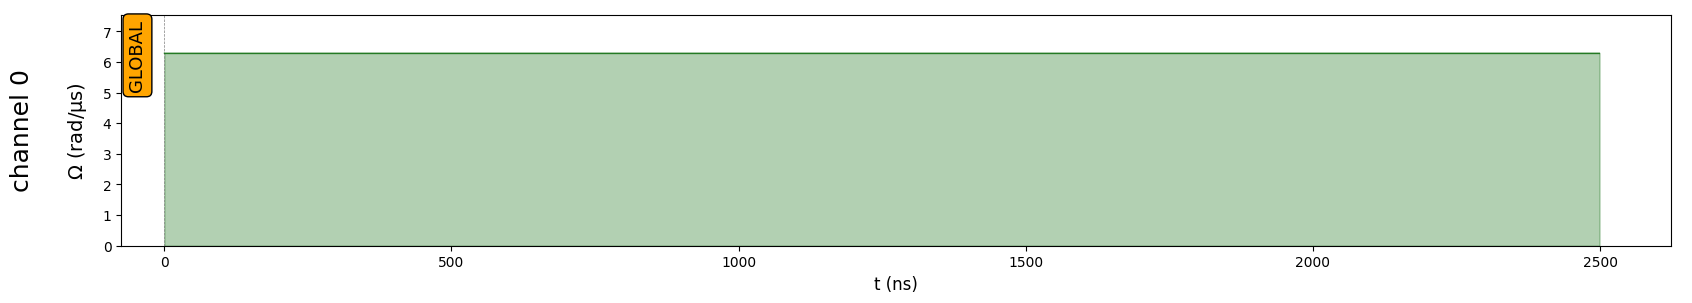

In [28]:
seq = Sequence(reg, Chadoq2)
seq.declare_channel("channel 0", "rydberg_global")
duration = 2500
pulse = Pulse.ConstantPulse(duration, 2 * np.pi, 0.0, 0.0)
seq.add(pulse, "channel 0")
seq.draw()

We now create the simulation object

In [29]:
sim = Simulation(seq, sampling_rate=0.05)
sim.evaluation_times = 0.4
res_clean = sim.run()
obs = qutip.basis(2, 0).proj()
config_spam = SimConfig(noise=("SPAM"), runs=30, samples_per_run=5)

## Doppler noise

As for any noise, the doppler noise is set via a `SimConfig` object. When averaging over several runs, it has the effect of damping the oscillations. Let's increase the number of runs in order to observe it and get smoother curves.

Note that you may change the standard deviation of the doppler noise, which is $k \times \sqrt{k_B T / m}$, where $k$ is the norm of the effective wavevector of the lasers, by changing the temperature field, setting it in $\mu K$. We'll exaggerate the temperature field here to emphasize the effects of the doppler damping; the default value for temperature is 50 $\mu K$.

In [30]:
config_doppler = SimConfig(
    noise="doppler", runs=100, temperature=5000, samples_per_run=10
)
sim.set_config(config_doppler)
sim.show_config()

Options:
----------
Number of runs:        100
Samples per run:       10
Noise types:           doppler
Temperature:           5000.0µK


Let us now simulate the entire sequence with doppler noise, much like what we did in the SPAM case. We should see damped oscillations if the standard deviation is high enough. This is the case here, as we exaggerated the temperature field.

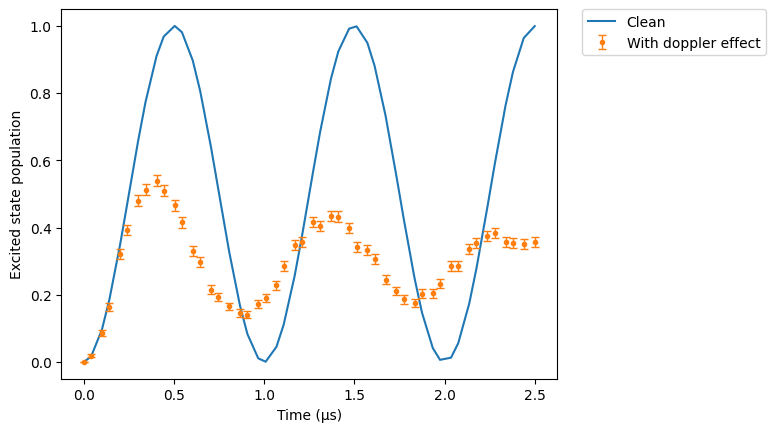

In [31]:
res_clean.plot(obs, label="Clean")
res_doppler = sim.run()
res_doppler.plot(obs, label="With doppler effect")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.0)
plt.ylabel("Excited state population")
plt.show()

## Amplitude noise

When activated, we switch to a description of the laser amplitude as a gaussian profile which standard deviation is the `laser_waist`. 
In addition the laser amplitude fluctuates according to a gaussian profile with standard deviation `amp_sigma`.

In [32]:
sim.reset_config()
config_amp_noise = SimConfig(
    noise="amplitude",
    runs=100,
)
sim.set_config(config_amp_noise)
sim.show_config()

Options:
----------
Number of runs:        100
Samples per run:       5
Noise types:           amplitude
Laser waist:           175.0μm
Amplitude standard dev.:  0.05


We observe that the apmlitude standard deviation `amp_sigma`, is quite low. We imposed it to between 0 and 1.

You may ask why using 100 runs instead of 10 times as for doppler noises. It's to have a good average since the amplitude of pulses is multiplied by two gaussian functions.

Let us now simulate the entire sequence with an amplitude noise, much like what we did in the SPAM case.

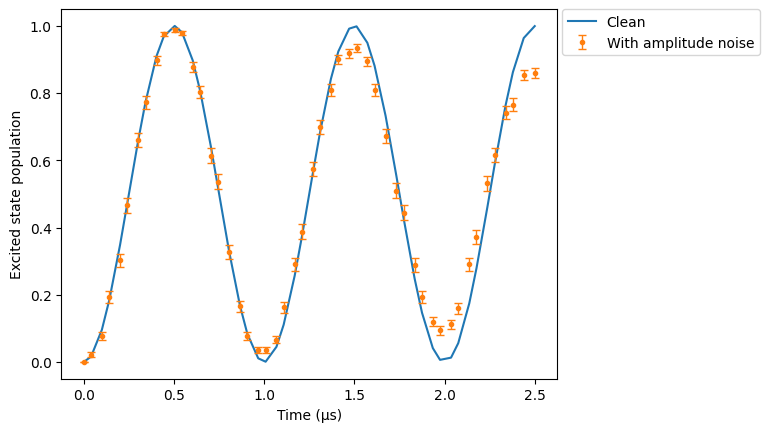

In [33]:
res_clean.plot(obs, label="Clean")
res_doppler = sim.run()
res_doppler.plot(obs, label="With amplitude noise")
plt.legend(bbox_to_anchor=(1.01, 1), loc="upper left", borderaxespad=0.0)
plt.ylabel("Excited state population")
plt.show()

We start to observe a damping, quite timid, of the excited state population.

Let's increase the `laser_waist` to $200 \mu m$ and `amp_sigma` to $0.1$ to have more pronounced effects.

In [34]:
sim.reset_config()
config_amp_noise = SimConfig(
    noise="amplitude", runs=100, laser_waist=200, amp_sigma=0.1
)
sim.set_config(config_amp_noise)
sim.show_config()

Options:
----------
Number of runs:        100
Samples per run:       5
Noise types:           amplitude
Laser waist:           200μm
Amplitude standard dev.:  0.1


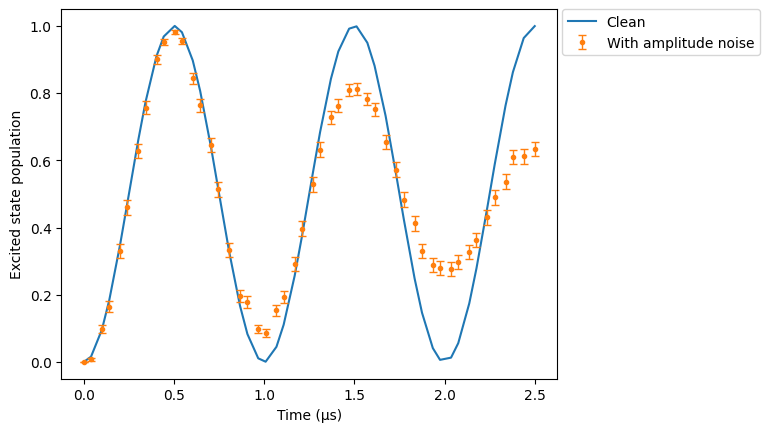

In [35]:
res_clean.plot(obs, label="Clean")
res_doppler = sim.run()
res_doppler.plot(obs, label="With amplitude noise")
plt.legend(bbox_to_anchor=(1.01, 1), loc="upper left", borderaxespad=0.0)
plt.ylabel("Excited state population")
plt.show()

In this case the damping is heavier compare to what we have at the beginning. But still, weaker than the one due to the doppler effect.

In the multi-qubit case, because of the gaussian profile of the laser amplitude, atoms at the border of the waist feel a slightly lower amplitude than those at the focus: which means more damping than what we observe in this one qubit case.

## Multiple Atoms

We will now run the AFM state preparation sequence from the Pulser tutorial with our noise models, and compare the results to the clean case.

At this stage, you know how to manipulate SPAM errors, and laser noises. In this multi-qubit case, we will sum-up all these effects.

In [36]:
# Parameters in rad/µs and ns
omega_max = 2.3 * 2 * np.pi
delta_0 = -6 * 2 * np.pi
delta_f = 2 * 2 * np.pi

t_rise = 252
t_fall = 500
t_sweep = (delta_f - delta_0) / (2 * np.pi * 10) * 1000

U = 2 * np.pi
R_interatomic = Chadoq2.rydberg_blockade_radius(U)

n_side = 3
reg = Register.rectangle(n_side, n_side, R_interatomic, prefix="q")

rise = Pulse.ConstantDetuning(
    RampWaveform(t_rise, 0.0, omega_max), delta_0, 0.0
)
sweep = Pulse.ConstantAmplitude(
    omega_max, RampWaveform(t_sweep, delta_0, delta_f), 0.0
)
fall = Pulse.ConstantDetuning(
    RampWaveform(t_fall, omega_max, 0.0), delta_f, 0.0
)

seq = Sequence(reg, Chadoq2)
seq.declare_channel("ising", "rydberg_global")

seq.add(rise, "ising")
seq.add(sweep, "ising")
seq.add(fall, "ising")

In [37]:
config_all_noise = SimConfig(
    noise=("SPAM", "doppler", "amplitude"), runs=100, samples_per_run=10
)
simul = Simulation(
    seq,
    sampling_rate=0.05,
    evaluation_times=0.1,
    config=config_all_noise,  # Take 10% of the time steps as evaluation times (7 time steps)
)
spam_results = simul.run()

simul.reset_config()
clean_results = simul.run()

We now plot the simulation results by sampling the final states. Notice that rather than using the `sample_final_state()` method on the SPAM results object (which just samples from the last realization of the noisy simulation), we need to extract the `Counter` object from the `NoisyResults.results` object, which has accumulated the samples of all the simulated runs.

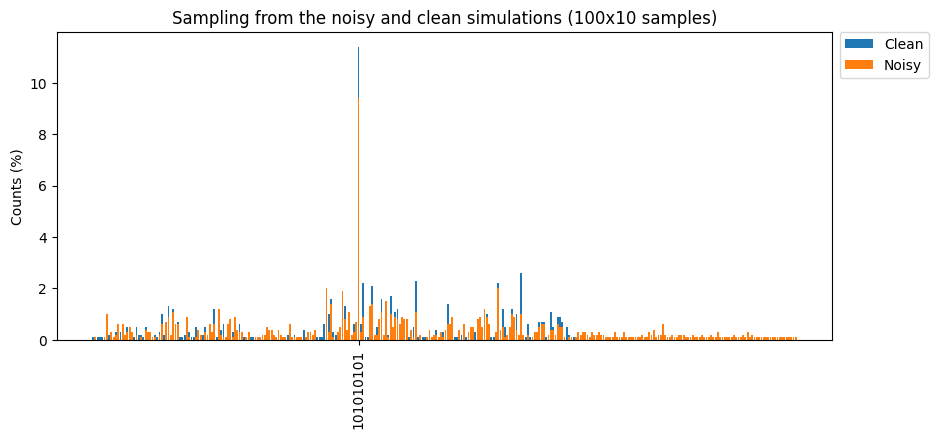

In [38]:
plt.figure(figsize=(10, 4))
noisy_count = spam_results.results[
    -1
]  # Extract the Counter object from the last evaluated time step.
clean_count = clean_results.sample_final_state(
    N_samples=100 * 10
)  # Compare with 100 runs of 10 samples each

clean_most_freq = {k: 100 * v / 1000 for k, v in clean_count.items()}
noisy_most_freq = {k: 100 * v for k, v in noisy_count.items()}

plt.bar(clean_most_freq.keys(), list(clean_most_freq.values()), label="Clean")
plt.bar(noisy_most_freq.keys(), list(noisy_most_freq.values()), label="Noisy")

# Only show the xticks to the most frequent states:
most_freq = sorted(noisy_count, key=noisy_count.get, reverse=True)[:1]

plt.ylabel("Counts (%)")
plt.xticks(most_freq, rotation=90)
plt.title("Sampling from the noisy and clean simulations (100x10 samples)")
plt.legend(bbox_to_anchor=(1.01, 1), loc="upper left", borderaxespad=0.0)
plt.show()

The bars represent the simulation results as populations of bitstrings. They're colored blue for the noiseless simulation, and orange for the noisy one. We clearly identify the antiferromagnetic state as the most populated one in both cases, but it is slightly less populated in the noisy case, while some other bitstrings, not present in the noiseless case, appear.